In [1]:
import tqdm
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True), 
            nn.Linear(256, 128), 
            nn.ReLU(True), 
            nn.Linear(128, embedding_size)
        )
    
    def forward(self, x):
        return self.fc(x)

In [3]:
class Decoder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True), 
            nn.Linear(512, 28 * 28), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.enc = Encoder(embedding_size)
        self.dec = Decoder(embedding_size)

    def forward(self, x):
        return self.dec(self.enc(x))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 10
batch_size = 128
embedding_size = 64
lr = 1e-3
weight_decay = 1e-6
transform = transforms.ToTensor()
print(device)

cuda


In [6]:
train_data = datasets.MNIST('data/', train=True, download=True, transform=transform)
val_data = datasets.MNIST('data/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True, drop_last=True)
x, y = next(iter(train_loader))
print(len(train_data), len(val_data), x.shape, y.shape)

60000 10000 torch.Size([128, 1, 28, 28]) torch.Size([128])


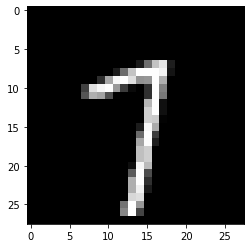

In [7]:
img, _ = train_data[42]
plt.imshow(img[0], cmap='gray')

In [8]:
net = AutoEncoder(embedding_size).to(device)
inp = torch.randn(10, 784).to(device)
out = net(inp)
print(out.shape)
del inp, out
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

torch.Size([10, 784])


In [9]:
def loop(net, loader, epoch, is_train):
    net.train(is_train)
    losses = []
    pbar = tqdm.tqdm(loader, total=len(loader))
    for x, _ in pbar:
        with torch.set_grad_enabled(is_train):
            x = x.view(x.shape[0], -1).to(device)
            preds = net(x)
            loss = loss_fn(preds, x)
            losses.append(loss.item())
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        pbar.set_description(f'epoch={epoch}, train={int(is_train)}')
        pbar.set_postfix(avg_loss=f'{np.mean(losses):.4f}')

In [10]:
for epoch in range(n_epochs):
    loop(net, train_loader, epoch, True)
    loop(net, val_loader, epoch, False)

epoch=9, train=0: 100%|██████████| 78/78 [00:02<00:00, 38.71it/s, avg_loss=0.0135]


In [11]:
@torch.no_grad()
def plot_examples(loader):
    net.eval()
    x, _ = next(iter(loader))
    x = x.view(x.shape[0], -1).to(device)
    x_hat = net(x)
    x = x.view(x.shape[0], 28, 28)
    x_hat = x_hat.view(x.shape[0], 28, 28)
    rows = torch.cat([x, x_hat], axis=1)
    imgs = torch.cat([rows[i] for i in range(42, 52)], axis=1).cpu().detach()
    plt.figure(figsize=(20, 5))
    plt.imshow(imgs, cmap='gray')
    plt.axis('off')

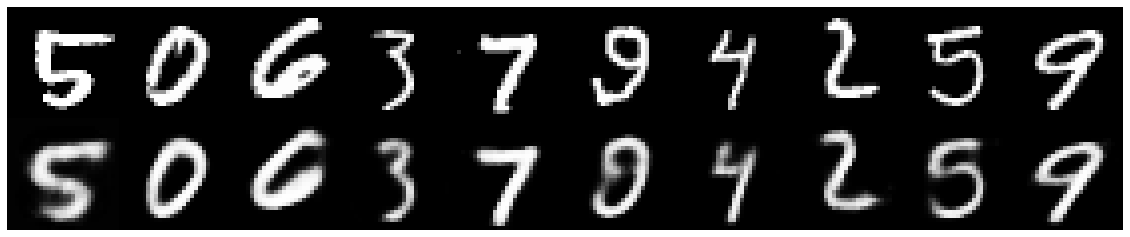

In [12]:
plot_examples(train_loader)

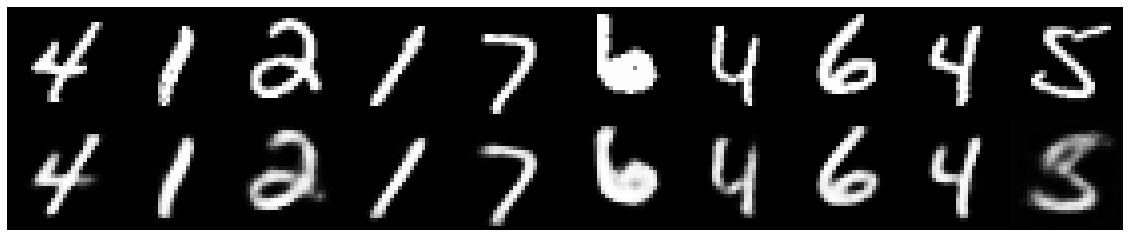

In [13]:
plot_examples(val_loader)